In [660]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import yeojohnson
from scipy.stats import boxcox
from sklearn.feature_selection import mutual_info_regression

In [661]:
df = pd.read_csv('../data/raw/mbajk_dataset.csv')

In [662]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18692 entries, 0 to 18691
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 18692 non-null  int64  
 1   date                       18692 non-null  object 
 2   temperature                16823 non-null  float64
 3   relative_humidity          18692 non-null  int64  
 4   dew_point                  18692 non-null  float64
 5   apparent_temperature       18692 non-null  float64
 6   precipitation_probability  17384 non-null  float64
 7   rain                       15888 non-null  float64
 8   surface_pressure           18692 non-null  float64
 9   bike_stands                18692 non-null  int64  
 10  available_bike_stands      18692 non-null  int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 1.6+ MB


In [663]:
df.shape

(18692, 11)

In [664]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.isnull().sum()

date                            0
temperature                  1869
relative_humidity               0
dew_point                       0
apparent_temperature            0
precipitation_probability    1308
rain                         2804
surface_pressure                0
bike_stands                     0
available_bike_stands           0
dtype: int64

In [665]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:07:30+00:00,25.1,45,12.4,24.7,0.0,0.0,984.3,22,8
1,2023-06-25 20:25:41+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8
2,2023-06-25 20:12:20+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,12
3,2023-06-25 19:33:48+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,7
4,2023-06-25 19:55:29+00:00,24.2,43,10.9,23.3,NaN,0.0,984.5,22,8


In [666]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['date'], inplace=True)

In [667]:
input_data = df.columns.tolist()
input_data.remove('date')
output_data = df.columns[df.isnull().any()].tolist()

for column in output_data:
    df_copy = df.copy()
    for i in output_data:
        if i != column:
            df_copy[i] = df_copy[i].fillna(df_copy[i].mean())
            
    input_data_copy = input_data.copy()
    input_data_copy.remove(column)
    
    df_missing = df_copy[df_copy[column].isnull()]
    df_not_missing = df_copy[df_copy[column].notnull()]
    
    X_train, X_test, y_train, y_test = train_test_split(df_not_missing[input_data_copy], df_not_missing[column], test_size=0.30)
    reg = RandomForestRegressor().fit(X_train, y_train)
    pred = reg.predict(df_missing[input_data_copy])
    df.loc[df_missing.index, column] = pred
    
df.isnull().sum()

date                         0
temperature                  0
relative_humidity            0
dew_point                    0
apparent_temperature         0
precipitation_probability    0
rain                         0
surface_pressure             0
bike_stands                  0
available_bike_stands        0
dtype: int64

In [668]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-06-25 19:07:30+00:00,25.1,45,12.4,24.7,0.00,0.0,984.3,22,8
3,2023-06-25 19:33:48+00:00,24.2,43,10.9,23.3,0.00,0.0,984.5,22,7
5,2023-06-25 19:45:44+00:00,24.2,43,10.9,23.3,0.00,0.0,984.5,22,6
4,2023-06-25 19:55:29+00:00,24.2,43,10.9,23.3,2.27,0.0,984.5,22,8
6,2023-06-25 20:02:16+00:00,24.2,43,10.9,23.3,0.00,0.0,984.5,22,12


In [669]:
def data_timeseries_graph():
    plt.figure(figsize=(20, 6))
    plt.plot(df['date'], df['available_bike_stands'])
    plt.title('Available bikes')
    plt.xlabel('Time')
    plt.ylabel('Numer of available bikes')
    plt.grid(True)
    plt.show()

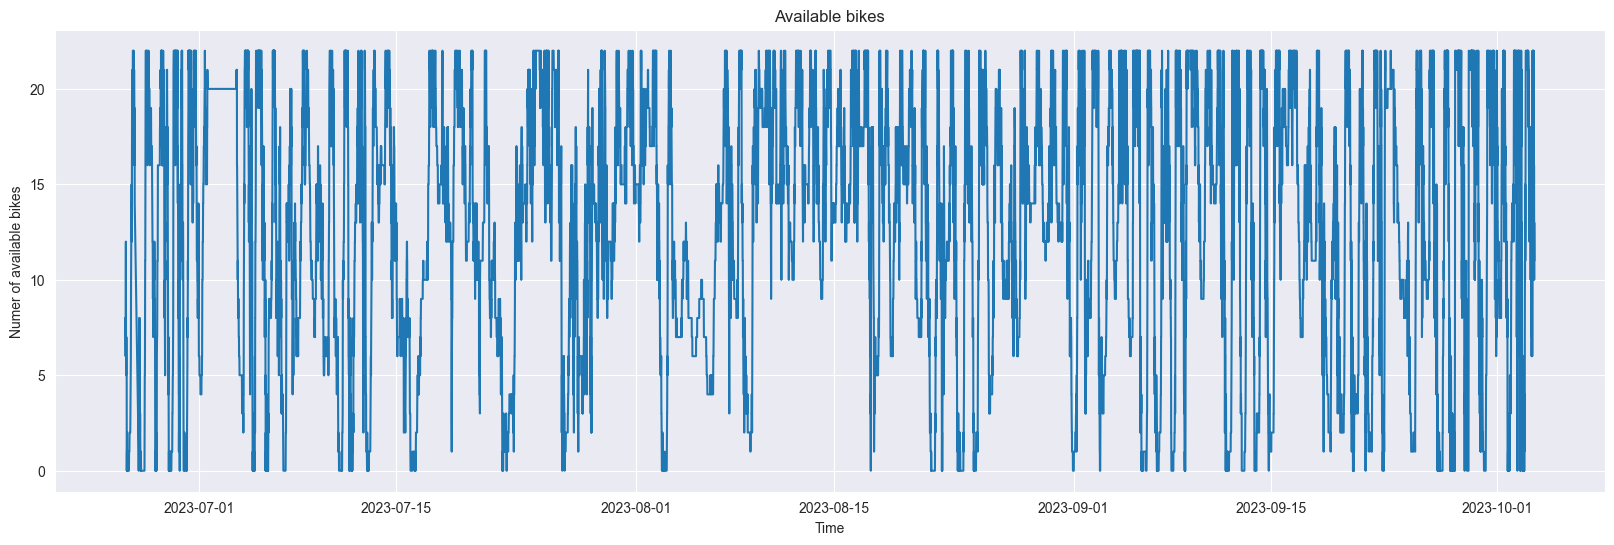

In [670]:
data_timeseries_graph()

In [671]:
df.dtypes

date                         datetime64[ns, UTC]
temperature                              float64
relative_humidity                          int64
dew_point                                float64
apparent_temperature                     float64
precipitation_probability                float64
rain                                     float64
surface_pressure                         float64
bike_stands                                int64
available_bike_stands                      int64
dtype: object

In [672]:
for col in input_data:
    if df[col].nunique() == 1:
        print(f'Column: {col} has only one unique value (constant feature and will be removed)')
        df.drop(col, axis=1, inplace=True)
        input_data.remove(col)

Column: bike_stands has only one unique value (constant feature and will be removed)


In [673]:
def transform_data(col):
    df[col], _  = boxcox(df[col])
    
def transform_zero_neg_data(col):
    df[col], _ = yeojohnson(df[col])

In [674]:
output_data = 'available_bike_stands'
input_data.remove(output_data)

columns = df.columns.tolist()
columns.remove('date')
columns.remove(output_data)

columns_with_zero_or_neg = []
for i in columns:
    if (df[i] <= 0).any():
        columns_with_zero_or_neg.append(i)
        
columns = list(filter(lambda x: x not in columns_with_zero_or_neg, columns))

print(f'Columns with zero or negative values: {columns_with_zero_or_neg}')
print(f'Columns without zero or negative values: {columns}')

Columns with zero or negative values: ['precipitation_probability', 'rain']
Columns without zero or negative values: ['temperature', 'relative_humidity', 'dew_point', 'apparent_temperature', 'surface_pressure']


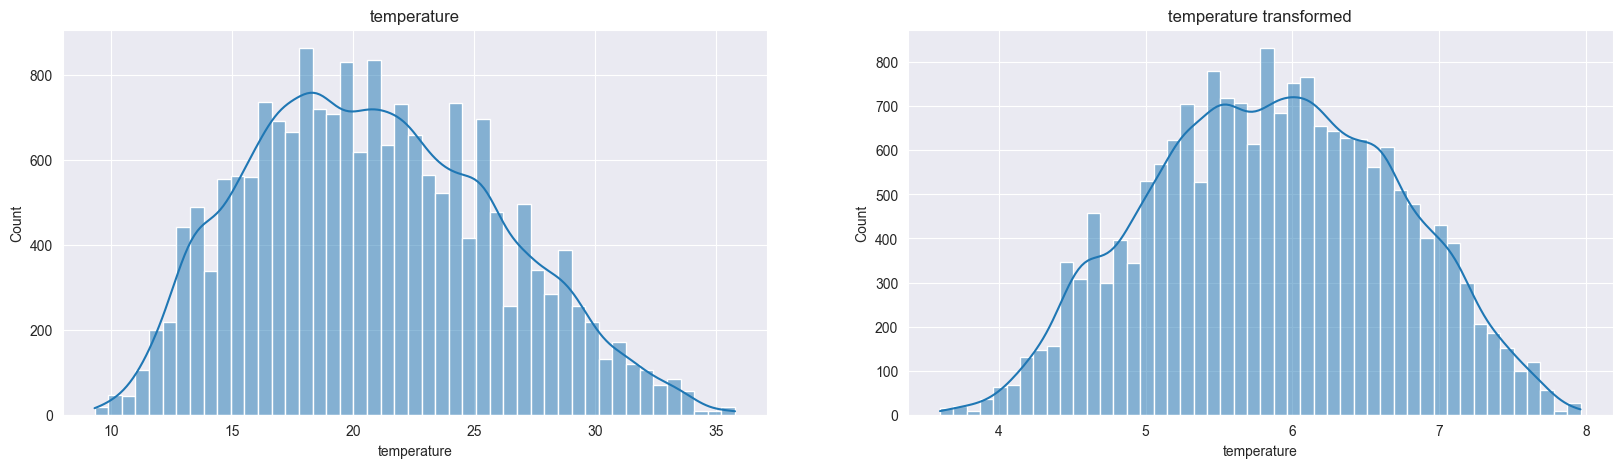

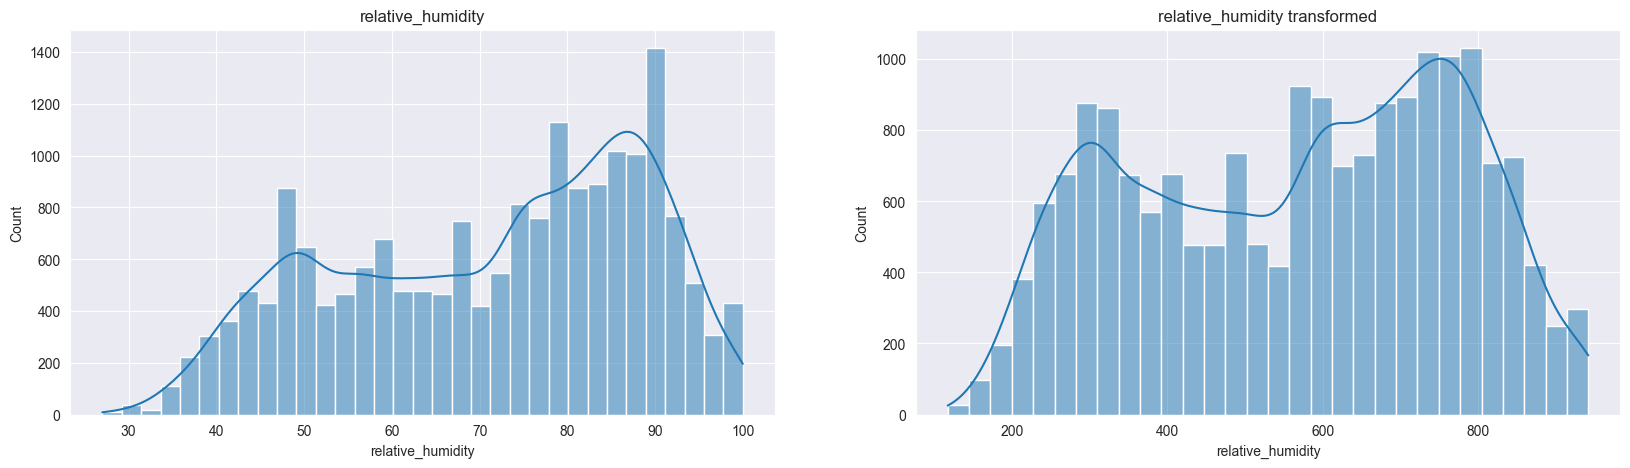

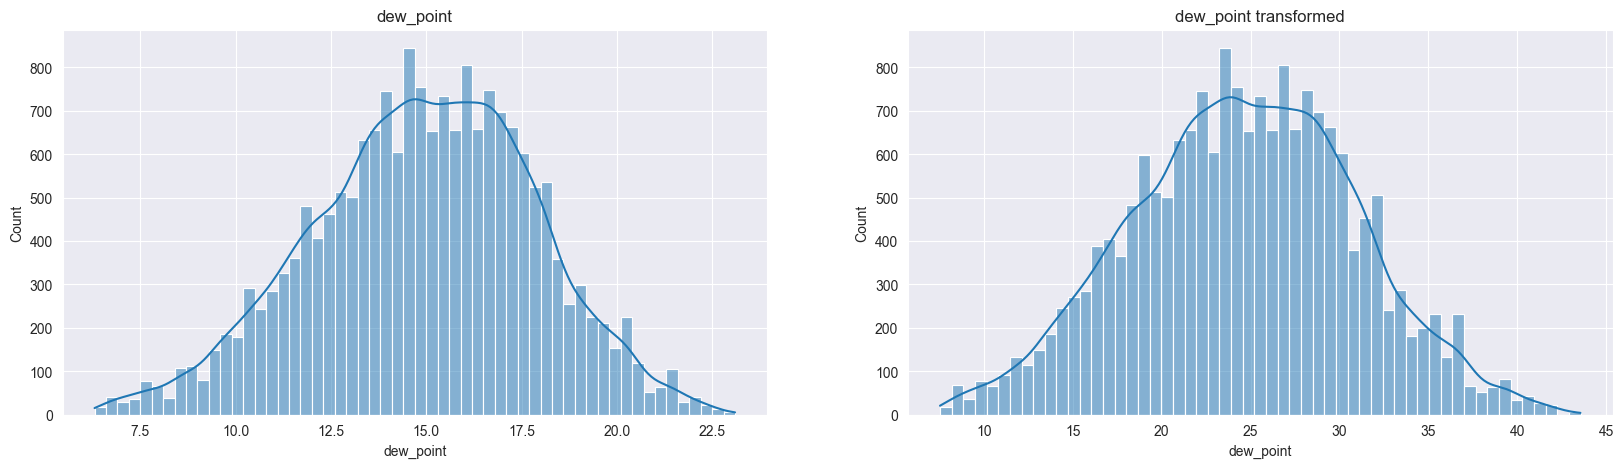

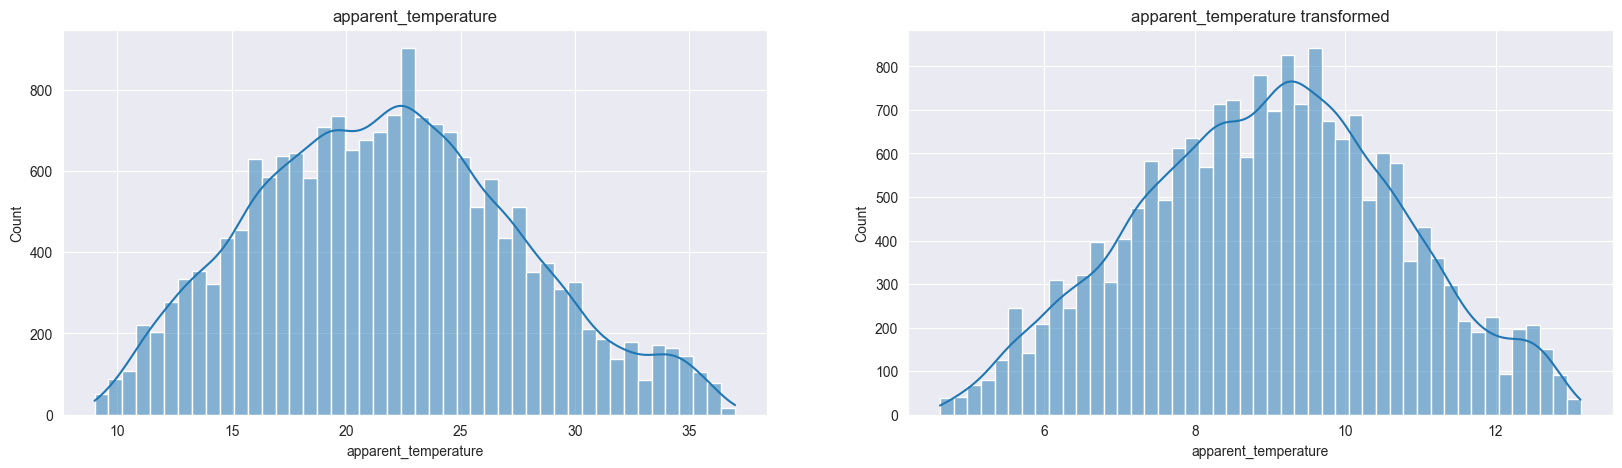

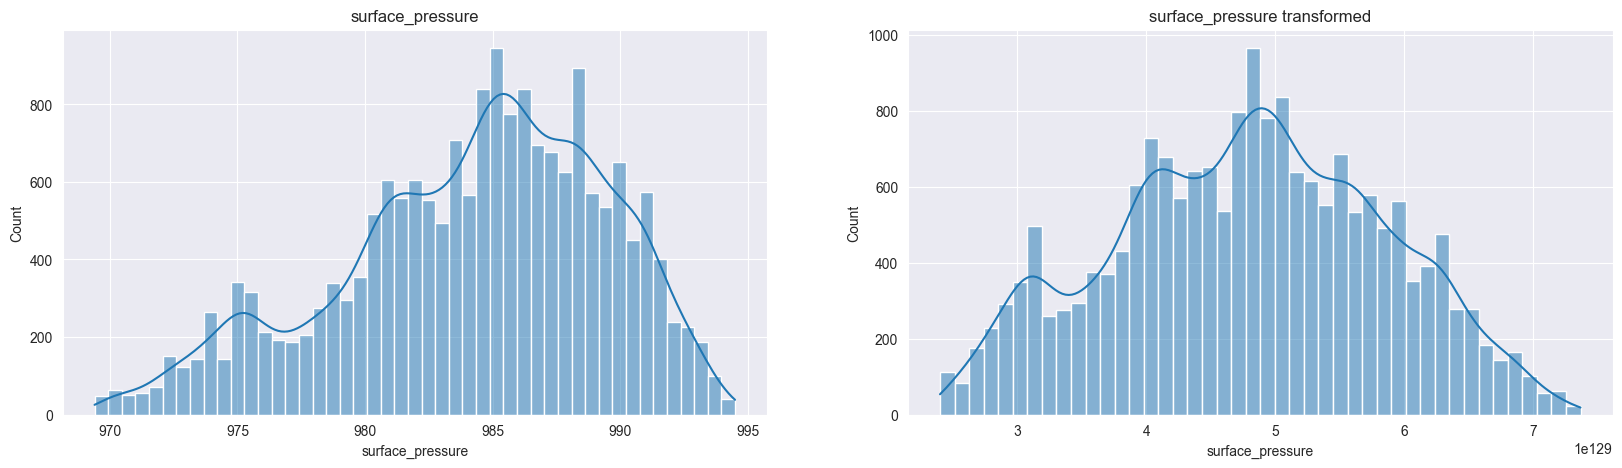

In [675]:
for i in columns:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    ax[0].set_title(i)
    sns.histplot(data=df, x=i, kde=True, ax=ax[0])
    
    transform_data(i)
    
    sns.histplot(data=df, x=i, kde=True, ax=ax[1])
    ax[1].set_title(f'{i} transformed')
    
    plt.show()

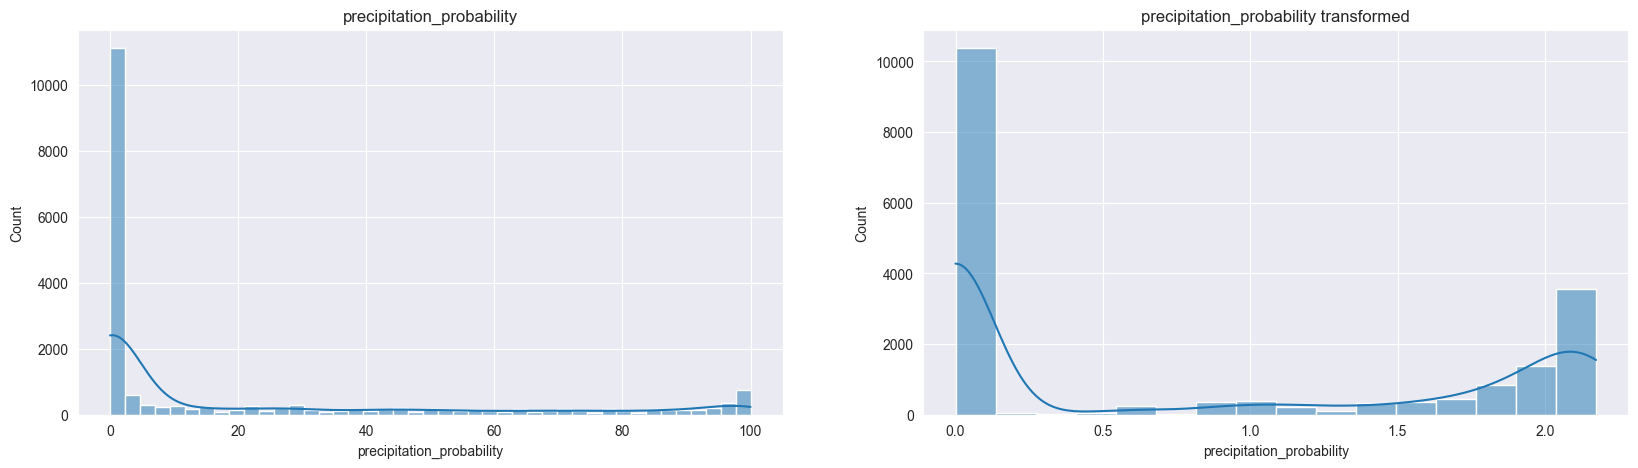

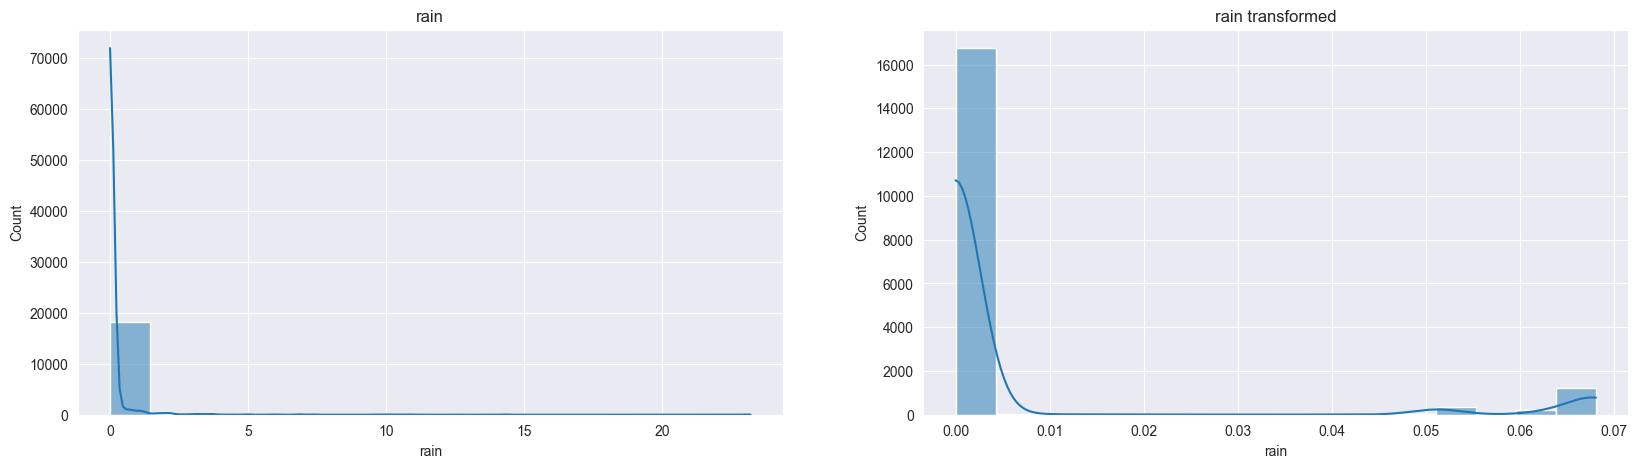

In [676]:
for i in columns_with_zero_or_neg:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    ax[0].set_title(i)
    sns.histplot(data=df, x=i, kde=True, ax=ax[0])
    
    transform_zero_neg_data(i)
    
    sns.histplot(data=df, x=i, kde=True, ax=ax[1])
    ax[1].set_title(f'{i} transformed')
    
    plt.show()

In [681]:
df.head(10)

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,available_bike_stands
0,2023-06-25 19:07:30+00:00,6.575747,264.602151,19.112706,9.911638,0.00000,0.0,4.685082e+129,8
3,2023-06-25 19:33:48+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,7
5,2023-06-25 19:45:44+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,6
4,2023-06-25 19:55:29+00:00,6.444121,246.135484,16.068919,9.508868,0.95361,0.0,4.727029e+129,8
6,2023-06-25 20:02:16+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,12
2,2023-06-25 20:12:20+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,12
1,2023-06-25 20:25:41+00:00,6.444121,246.135484,16.068919,9.508868,0.95361,0.0,4.727029e+129,8
7,2023-06-25 20:34:07+00:00,6.030658,364.097512,18.494987,9.036745,0.00000,0.0,4.706010e+129,5
8,2023-06-25 20:45:23+00:00,6.030658,364.097512,18.494987,9.036745,0.00000,0.0,4.706010e+129,7
9,2023-06-25 20:52:46+00:00,6.030658,364.097512,18.494987,9.036745,0.00000,0.0,4.706010e+129,7


In [680]:
df.to_csv('../data/processed/mbajk_dataset.csv', index=False)